# Spectrum broadening

In this section we will discuss the broadening of calculated spectra, and how they compare to the different broadening mechanisms of experimental measurements. As an example, we will consider the valence spectrum of water, calculated as:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import veloxchem as vlx

au2ev = 27.2113245

water_xyz = """3

O       0.0000000000     0.1178336003     0.0000000000
H      -0.7595754146    -0.4713344012     0.0000000000
H       0.7595754146    -0.4713344012     0.0000000000 
"""

# Prepare molecule and basis objects
molecule = vlx.Molecule.read_xyz_string(water_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.
* Info * Reading basis set from file: /home/thomas/Notebook/anaconda/envs/echem/lib/python3.10/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                               

In [5]:
import py3Dmol as p3d
viewer = p3d.view(width=300, height=200)
viewer.addModel(water_xyz, 'xyz')
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick":{},"sphere": {"scale":0.25}})
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [ ]:
# SCF settings and calculation
scf_drv = vlx.ScfRestrictedDriver()
scf_settings = {"conv_thresh": 1.0e-6}
method_settings = {"xcfun": "b3lyp"}
scf_drv.update_settings(scf_settings, method_settings)
scf_results = scf_drv.compute(molecule, basis)

# resolve four eigenstates
rpa_solver = vlx.lreigensolver.LinearResponseEigenSolver()
rpa_solver.update_settings({"nstates": 6}, method_settings)
rpa_results = rpa_solver.compute(molecule, basis, scf_results)

With excited state energies, oscillator strengths, and transition moments:

In [2]:
print("Energy [au]  Osc. str.   TM(x)     TM(y)     TM(z)")
for i in np.arange(len(rpa_results["eigenvalues"])):
    e, os, x, y, z = (
        rpa_results["eigenvalues"][i],
        rpa_results["oscillator_strengths"][i],
        rpa_results["electric_transition_dipoles"][i][0],
        rpa_results["electric_transition_dipoles"][i][1],
        rpa_results["electric_transition_dipoles"][i][2],
    )
    print("   {:.3f}     {:8.5f}  {:8.5f}  {:8.5f}  {:8.5f}".format(e, os, x, y, z))

Energy [au]  Osc. str.   TM(x)     TM(y)     TM(z)
   0.286      0.01128   0.00000  -0.00000   0.24321
   0.364      0.09652  -0.00000   0.63080   0.00000
   0.364      0.00000  -0.00000   0.00000   0.00000
   0.454      0.08684   0.53570   0.00000   0.00000
   0.540      0.41655   1.07524  -0.00000  -0.00000
   0.666      0.24377   0.00000   0.74073  -0.00000


## Broadening in experiment

The line shape of an experimental spectrum is affected by a number of factors, including:

- [Life-time broadening](https://en.wikipedia.org/wiki/Spectral_line#Natural_broadening)

- Resolution of measurement

- Vibrational effects

- [Doppler broadening](https://en.wikipedia.org/wiki/Doppler_broadening)

These leads to a number of different broadening types, such as

- [Lorentzian](https://en.wikipedia.org/wiki/Spectral_line_shape#Lorentzian) (*homogenous?*)<br>
  From life-time broadening
  
- [Gaussian](https://en.wikipedia.org/wiki/Spectral_line_shape#Gaussian) (*inhomogenous?*) <br>
  From Doppler broadening and resolution of measurement
    
- [Voigt](https://en.wikipedia.org/wiki/Spectral_line_shape#Voigt) <br>
  A convolution of a Gaussian and a Lorentzian
  
- Asymmetric <br>
  From vibrational effects
  
  
## Lorentzian 
  
Cauchy distribution $f$

$$
f ( \omega ; \omega_k, \gamma_k) = \frac{1}{\pi}
\left[
\frac{\gamma_k}{(\omega_k - \omega)^2 + \gamma_k^2}
\right]
$$

with FWHM of $2\gamma_k$. This is normalized

$$
\int_{-\infty}^{+\infty} f ( \omega ; \omega_k, \gamma_k) d \omega = 1.
$$

Amplitude $1/(\gamma \pi)$.
  
## Gaussian

$$
g ( \omega ; \omega_k, \sigma_k) = \frac{\sqrt{2}}{\sigma \sqrt{\pi}}
\textrm{exp}\left(
-\frac{2 (\omega - \omega_k)^2}{\sigma_k^2}
\right)
$$

HWHM is $\sigma \sqrt{\textrm{ln 2}}/{\sqrt{2}}$
  
## Voigt 

  
## Broadening calculated spectrum

Considering only a single feature, a Lorentzian and Gaussian convolution leads to features:

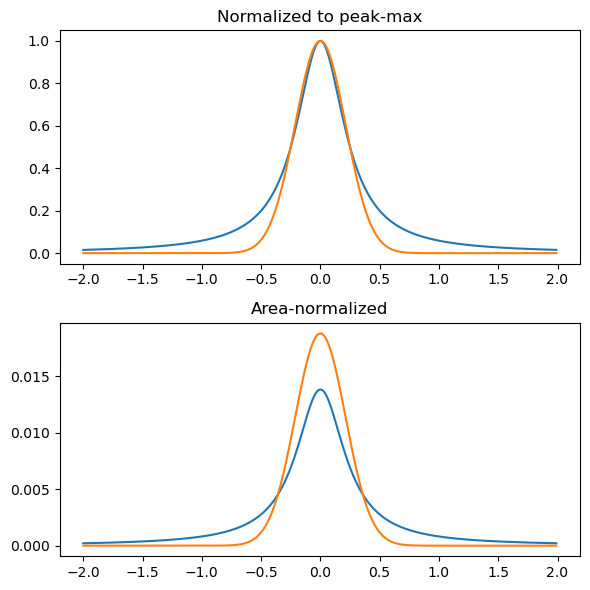

In [42]:
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)):
            yi[i] = (
                yi[i]
                + y[k] * gamma / ((xi[i] - x[k]) ** 2 + (gamma / 2.0) ** 2) / np.pi
            )
    return xi, yi


def gaussian(x, y, xmin, xmax, xstep, sigma):
    xi = np.arange(xmin, xmax, xstep)
    yi = np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(y)):
            yi[i] = yi[i] + y[k] * np.e ** (-((xi[i] - x[k]) ** 2) / (2 * sigma ** 2))
    return xi, yi

X = [0,0,0]
Y = [0,1,0]

plt.figure(figsize=(6, 6))
plt.subplot(211)
plt.title('Normalized to peak-max')
xi, yi = lorentzian(X, Y, -2, 2, 0.01, 0.5)
plt.plot(xi, yi/max(yi), label='Lorentzian')
xi, yi = gaussian(X, Y, -2, 2, 0.01, 0.5 / np.sqrt(4*2*np.log(2)))
plt.plot(xi, yi/max(yi), label='Gaussian')

plt.subplot(212)
plt.title('Area-normalized')
xi, yi = lorentzian(X, Y, -2, 2, 0.01, 0.5)
plt.plot(xi, yi/sum(yi), label='Lorentzian')
xi, yi = gaussian(X, Y, -2, 2, 0.01, 0.5 / np.sqrt(4*2*np.log(2)))
plt.plot(xi, yi/sum(yi), label='Gaussian')
plt.tight_layout()
plt.show()